In [1]:
import os
import numpy as np
import pandas as pd
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.warp import reproject, Resampling
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches
from dbfread import DBF

# Visualizing Vegetation and Topographic Data

## About the Data Sources

### Landfire

The LANDFIRE (LF) Program began because of increased concern about the number, severity, and size of wildland fires and the need for consistent national biological/ecological inventory data. Over the past decade, LF data have become a critical piece to wildland fire and fuels treatment research, modeling, and planning tools as well as operational support for wildland fire management. LF data are crucial to fire modeling to support both operational decision making and fuels planning.

LF is a cornerstone of a fully integrated national data information framework developing and improving vegetation and fuels data products based on the best available authoritative data and science in an all lands landscape conservation approach based on inter-agency/inter-organizational collaboration and cooperation. LF is acknowledged for management excellence and effective mission delivery.

LF relies heavily on remote sensing platforms like Landsat, field validation, and advanced GIS and modeling techniques to integrate diverse data sources for landscape-scale ecological modeling.

<p style="text-align: center;">
    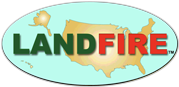
</p>


### Hawai'i Climate Data Portal (HCDP)

The idea for a centralized repository that can host quality-controlled climate data as well as gridded climate products for Hawai‘i has been in the making for over a decade, however, a lack of resources as well as several technical limitations have prevented its development. Beginning in 2018, as part of the Established Program to Stimulate Competitive Research (ESPCoR) ‘Ike Wai project, scientists from the Department of Geography and Environment (UHM), Hawai‘i Data Science Institute (UHM), the Water Resources Research Center (WRRC, UH) and the East-West center (EWC), joined forces and began working on an open source data and information sharing platform that has become Hawai‘i Climate Data Portal (HCDP).  

The overarching goal of the HCDP is to provide streamlined access to high-quality reliable climate data and information for the State of Hawai‘i. This includes the production of both near-real-time monthly rainfall and daily temperature maps and a user-friendly tool to visualize and download them. Easy access to high quality climate data, information and products through the HCDP allows researchers to focus more time on their analyses and less time on data collection and processing. It also provides the broader community with access to information that would otherwise be inaccessible due to technical limitations. Finally, centralizing data and information helps to create more of a holistic environment for environmental stewardship in Hawai‘i.

HCDP uses a combination of satellite data, ground-based observations, and advanced data assimilation methods to provide detailed climatic and ecological information specific to Hawai'i, supporting fire risk analysis and other environmental applications.

<p style="text-align: center;">
    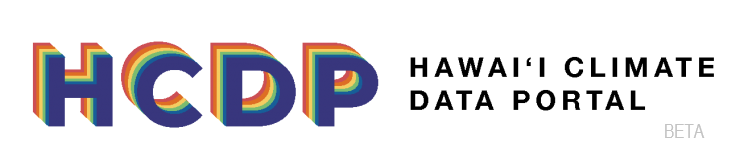
</p>

## About the Data

### 13 Anderson Fire Behavior Fuel Model (FBFM13)

Description:

    - The Anderson’s Fuel Model classifies areas based on the type and quantity of vegetation fuel. It categorizes the landscape into different types such as grass, brush, timber, and slash. Each fuel model has its own characteristic fire behavior, such as rate of spread and flame length.

Relation to Fire Susceptibility:

    - Fuel Types and Fire Behavior: Certain fuel models, like grass and brush, support fast-spreading fires, while others, such as timber, may burn more slowly but with higher intensity.
    
    - Fuel Load Management: Understanding the fuel model distribution helps in managing areas with high fire risk by implementing fuel treatments or controlled burns to reduce potential fire intensity.

### Existing Vegetation Type (EVT)

Description:

    - EVT provides a classification of the types of vegetation present in the area, such as grasslands, forests, shrublands, and other plant communities. The VAT file associated with EVT data typically maps codes to vegetation types.

Relation to Fire Susceptibility:

    - Fuel Load and Composition: Different vegetation types have varying fuel loads and compositions, influencing fire intensity and spread. For instance:
        - Grasslands and shrubs may ignite quickly and spread fires rapidly.
        - Forested areas may have heavier fuel loads, leading to more intense and longer-lasting fires.
        
    - Fire-Resilient Species: Some vegetation types are more resistant to fire, influencing how fires behave and spread in those areas.

### Normalized Difference Vegetation Index (NDVI)

Description:

    - NDVI is an index that measures vegetation health and density using satellite data. Values range from -1 to 1, with higher values indicating healthier, denser vegetation and lower values representing barren areas.
    
    - NDVI is calculated based on the difference between near-infrared (NIR) and red light reflected by vegetation.

Relation to Fire Susceptibility:

    - Vegetation Health and Moisture: Areas with high NDVI values generally have healthier, moisture-rich vegetation, which is less likely to ignite and sustain fires.
    
    - Seasonal Changes and Monitoring: NDVI can be used to monitor seasonal variations and drought conditions, providing insights into when vegetation is most vulnerable to fires. Lower NDVI values can indicate areas with stressed or dry vegetation, which are more susceptible to fires.

### Aspect

Description:

    - Aspect refers to the compass direction that a slope faces, measured in degrees (0–360°). For example, 0° is North, 90° is East, etc.
    
    - Aspect can significantly impact sunlight exposure and, consequently, vegetation type and moisture levels.

Relation to Fire Susceptibility:

    - South-Facing Slopes: These slopes receive more direct sunlight, leading to drier conditions and more flammable vegetation, making them more susceptible to fires.
    
    - North-Facing Slopes: In contrast, these slopes receive less sunlight, tend to retain moisture better, and are generally less prone to intense fire behavior.

### Slope

Description:

    The slope represents the steepness of the terrain. It is expressed in degrees or percentages. The values range from 0 (flat) to higher, indicating steeper inclines.

Relation to Fire Susceptibility:

    High Slope Increases Fire Spread: Fire tends to spread faster on steeper slopes because of the upward heat and flame movement. As the slope increases, fire behavior becomes more intense and difficult to control. Accessibility Issues: Steep slopes can hinder firefighting efforts, increasing the risk and difficulty of controlling fires.

### Elevation

Description:

    - Elevation indicates the height above sea level, typically in meters or feet.
    
    - This variable provides a measure of topography and landforms in the area.

Relation to Fire Susceptibility:

    - Vegetation Type and Moisture: Elevation can influence vegetation types and fuel moisture levels, both crucial factors in fire behavior. For example, lower elevations might have drier and more flammable vegetation, while higher elevations could have moister conditions that reduce fire spread.
    
    - Climate Influence: Different elevations experience variations in temperature, humidity, and wind, affecting fire susceptibility. Higher elevations may have cooler temperatures, but also potentially higher wind speeds that can drive fires.

## Visualize the Data

In [2]:
# Paths to GeoTIFF files
slope_path = 'C:\\Users\\T-Spe\\OneDrive\\School\\Fall \'25\\Master\'s Project\\test\\tifdata\\LH20_SlpP_220.tif'
elevation_path = 'C:\\Users\\T-Spe\\OneDrive\\School\\Fall \'25\\Master\'s Project\\test\\tifdata\\LH20_Elev_220.tif'
aspect_path = 'C:\\Users\\T-Spe\\OneDrive\\School\\Fall \'25\\Master\'s Project\\test\\tifdata\\LH20_Asp_220.tif'
evt_path = 'C:\\Users\\T-Spe\\OneDrive\\School\\Fall \'25\\Master\'s Project\\test\\tifdata\\LH22_EVT_230.tif'
fuel_model_path = 'C:\\Users\\T-Spe\\OneDrive\\School\\Fall \'25\\Master\'s Project\\test\\tifdata\\LH22_F13_230.tif'
ndvi_path = 'C:\\Users\\T-Spe\\OneDrive\\School\\Fall \'25\\Master\'s Project\\test\\tifdata\\ndvi\\03\\ndvi_16day_statewide_data_map_2022_03_06.tif'


### 13 Anderson Fire Behavior Fuel Model (FBFM13)

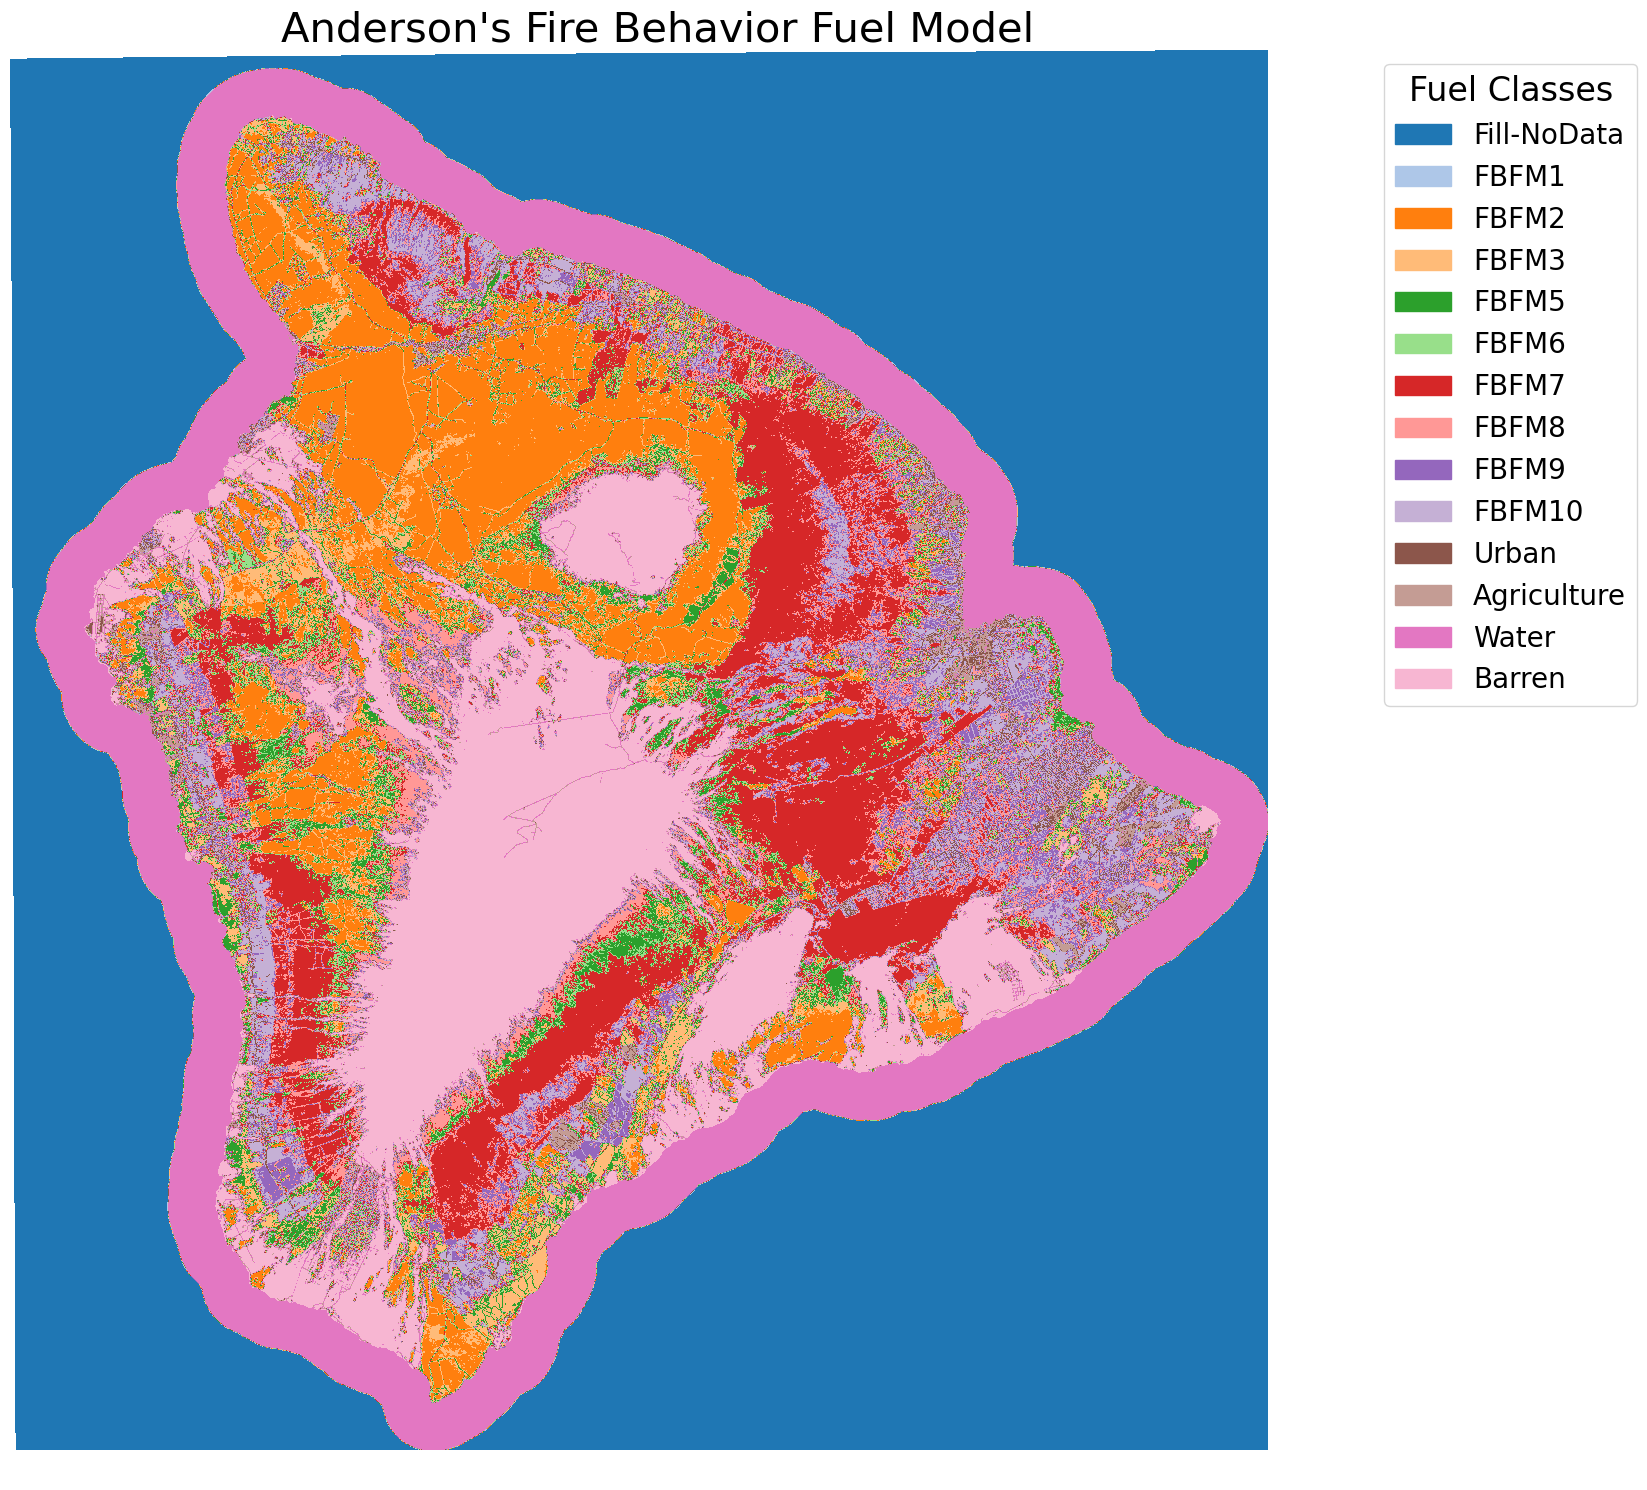

In [3]:
# **Load the Fuel Model data**
with rasterio.open(fuel_model_path) as fuel_model_dataset:
    fuel_model_data = fuel_model_dataset.read(1)
    fuel_model_transform = fuel_model_dataset.transform
    fuel_model_crs = fuel_model_dataset.crs
    fuel_model_nodata = fuel_model_dataset.nodata
    
# Read the VAT file
fuel_vat = DBF("C:/Users/T-Spe/OneDrive/School/Fall '25/Master's Project/test/tifdata/LH22_F13_230.tif.vat.dbf")
fuel_vat_df = pd.DataFrame(iter(fuel_vat))

# Sort the VAT DataFrame by VALUE
fuel_vat_df_sorted = fuel_vat_df.sort_values(by='VALUE').reset_index(drop=True)

# Create a mapping from pixel values to class names
fuel_value_to_class = dict(zip(fuel_vat_df['VALUE'], fuel_vat_df['FBFM13']))

# Map the Fuel Model data to class names
fuel_classes = np.vectorize(fuel_value_to_class.get)(fuel_model_data)

# Handle NoData values
fuel_classes = np.ma.masked_where(fuel_model_data == fuel_model_dataset.nodata, fuel_classes)

# Extract unique classes in the order of sorted VALUE
unique_fuel_classes = fuel_vat_df_sorted['FBFM13'].unique()

# Assign numeric labels based on sorted order
fuel_class_to_num = {cls: idx for idx, cls in enumerate(unique_fuel_classes)}
num_fuel_classes = len(unique_fuel_classes)

# Map class names to numeric labels
def map_fuel_class_to_num(class_name):
    return fuel_class_to_num.get(class_name, -1)  # Use -1 for unmapped classes

fuel_class_nums = np.vectorize(map_fuel_class_to_num)(fuel_classes)

# Mask invalid values and convert to integer
fuel_class_nums = np.ma.masked_equal(fuel_class_nums, -1)
fuel_class_nums = fuel_class_nums.astype(int)

# Generate a larger set of distinct colors
tab20_colors = plt.cm.tab20.colors
tab20b_colors = plt.cm.tab20b.colors
tab20c_colors = plt.cm.tab20c.colors

# Combine colors from multiple colormaps
combined_colors = tab20_colors + tab20b_colors + tab20c_colors

# If the number of classes exceeds available colors, cycle through them
if num_fuel_classes > len(combined_colors):
    extended_colors = list(cycle(combined_colors))
    colors = extended_colors[:num_fuel_classes]
else:
    colors = combined_colors[:num_fuel_classes]

# Create a ListedColormap
fuel_cmap = ListedColormap(colors)

# Create patches for each class
patches = [mpatches.Patch(color=colors[i], label=unique_fuel_classes[i]) for i in range(num_fuel_classes)]

# Compute the extent of the raster
xmin, ymin, xmax, ymax = fuel_model_dataset.bounds
extent = [xmin, xmax, ymin, ymax]

# Plot the Fuel Model data
fig, ax = plt.subplots(figsize=(20, 15))  # Increased figure size for better readability

im = ax.imshow(fuel_class_nums, cmap=fuel_cmap, extent=extent, origin='upper')
ax.set_title("Anderson's Fire Behavior Fuel Model", fontsize=30)
ax.axis('off')

# Add legend with patches
ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=20, title="Fuel Classes", title_fontsize=24, ncol=1)

plt.tight_layout()
plt.show()

In [4]:
# # Inspecting data structure
# print(fuel_vat_df.head)

### Existing Vegetation Type (EVT)

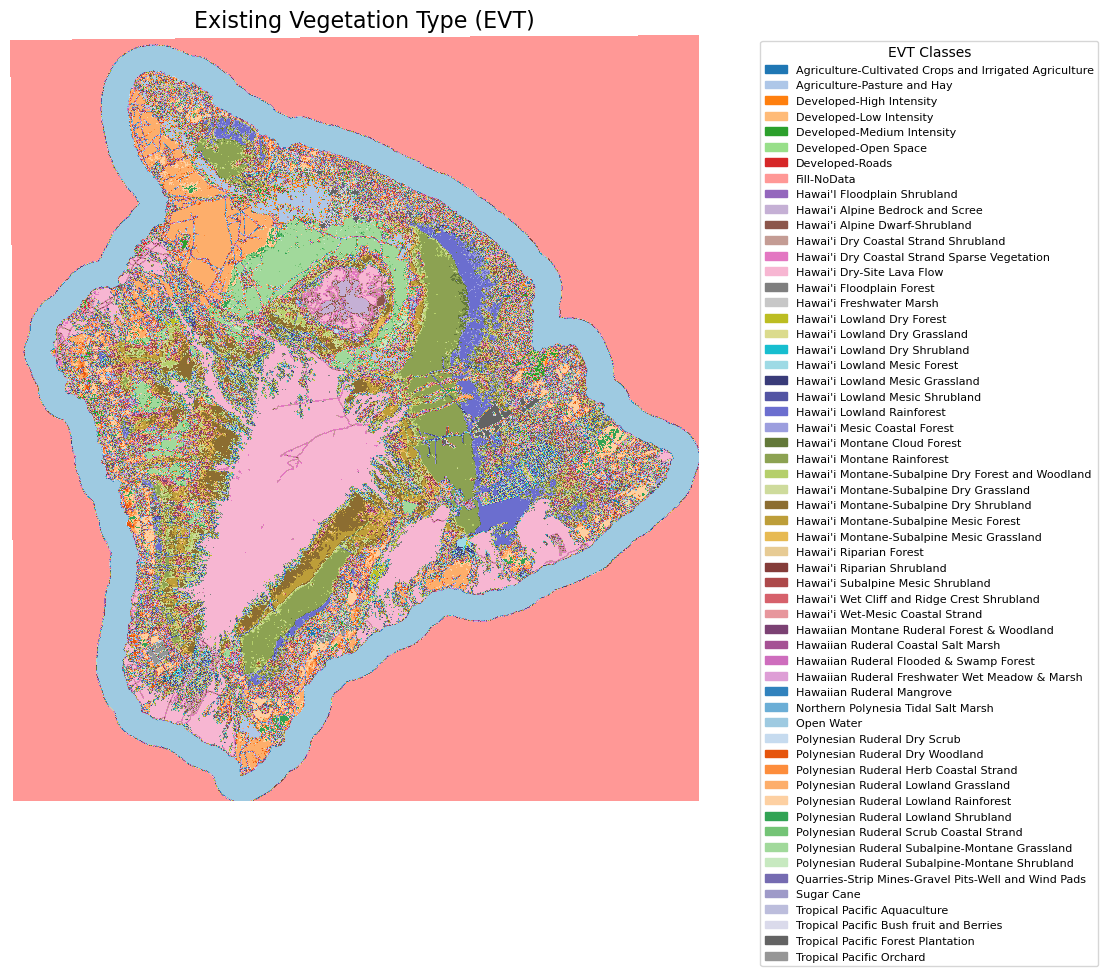

<Figure size 640x480 with 0 Axes>

In [5]:
# Load the EVT data
with rasterio.open(evt_path) as evt_dataset:
    evt_data = evt_dataset.read(1)
    evt_transform = evt_dataset.transform
    evt_crs = evt_dataset.crs
    evt_nodata = evt_dataset.nodata
    # Get the bounds of the raster
    xmin, ymin, xmax, ymax = evt_dataset.bounds
    
# Read the VAT file
vat = DBF("C:/Users/T-Spe/OneDrive/School/Fall '25/Master's Project/test/tifdata/LH22_EVT_230.tif.vat.dbf")
vat_df = pd.DataFrame(iter(vat))

# Create a mapping from pixel values to class names
value_to_class = dict(zip(vat_df['VALUE'], vat_df['EVT_NAME']))

# Map the EVT data to class names
evt_classes = np.vectorize(value_to_class.get)(evt_data)

# Handle NoData values
evt_classes = np.ma.masked_where(evt_data == evt_dataset.nodata, evt_classes)

# Get unique class names and assign numeric labels
unique_classes = np.unique(evt_classes.compressed())
class_to_num = {cls: idx for idx, cls in enumerate(unique_classes)}
num_classes = len(unique_classes)

# Map class names to numeric labels with default for unmapped
def map_class_name_to_num(class_name):
    return class_to_num.get(class_name, -1)  # Use -1 for unmapped classes

evt_class_nums = np.vectorize(map_class_name_to_num)(evt_classes)

# Mask invalid values and convert to integer
evt_class_nums = np.ma.masked_equal(evt_class_nums, -1)
evt_class_nums = evt_class_nums.astype(int)

# Generate a larger set of distinct colors
from itertools import cycle

# Use multiple colormaps to get more colors
tab20_colors = plt.cm.tab20.colors
tab20b_colors = plt.cm.tab20b.colors
tab20c_colors = plt.cm.tab20c.colors

# Combine colors
combined_colors = tab20_colors + tab20b_colors + tab20c_colors

# If number of classes exceeds available colors, cycle through them
if num_classes > len(combined_colors):
    extended_colors = list(cycle(combined_colors))
    colors = extended_colors[:num_classes]
else:
    colors = combined_colors[:num_classes]

# Create a ListedColormap
cmap = ListedColormap(colors)

# Create patches for each class
patches = [mpatches.Patch(color=colors[i], label=unique_classes[i]) for i in range(num_classes)]

# Plot EVT data
fig, ax = plt.subplots(figsize=(15, 10))
im = ax.imshow(evt_class_nums, cmap=cmap, extent=[xmin, xmax, ymin, ymax], origin='upper')
ax.set_title("Existing Vegetation Type (EVT)", fontsize=16)
ax.axis('off')
# 
# Add legend outside the plot
ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8, title="EVT Classes", title_fontsize=10)

plt.tight_layout()
plt.show()

# Create a colorbar with class names
# Create a norm with discrete boundaries
norm = BoundaryNorm(np.arange(num_classes + 1) - 0.5, num_classes)

# Add colorbar
cbar = plt.colorbar(im, ax=ax, fraction=0.02, pad=0.04, ticks=np.arange(num_classes))
cbar.ax.set_yticklabels(unique_classes, fontsize=8)
cbar.ax.tick_params(labelsize=10)

plt.show()

In [6]:
# # Inspecting data structure
# print(vat_df.head)

### Normalized Difference Vegetation Index (NDVI)

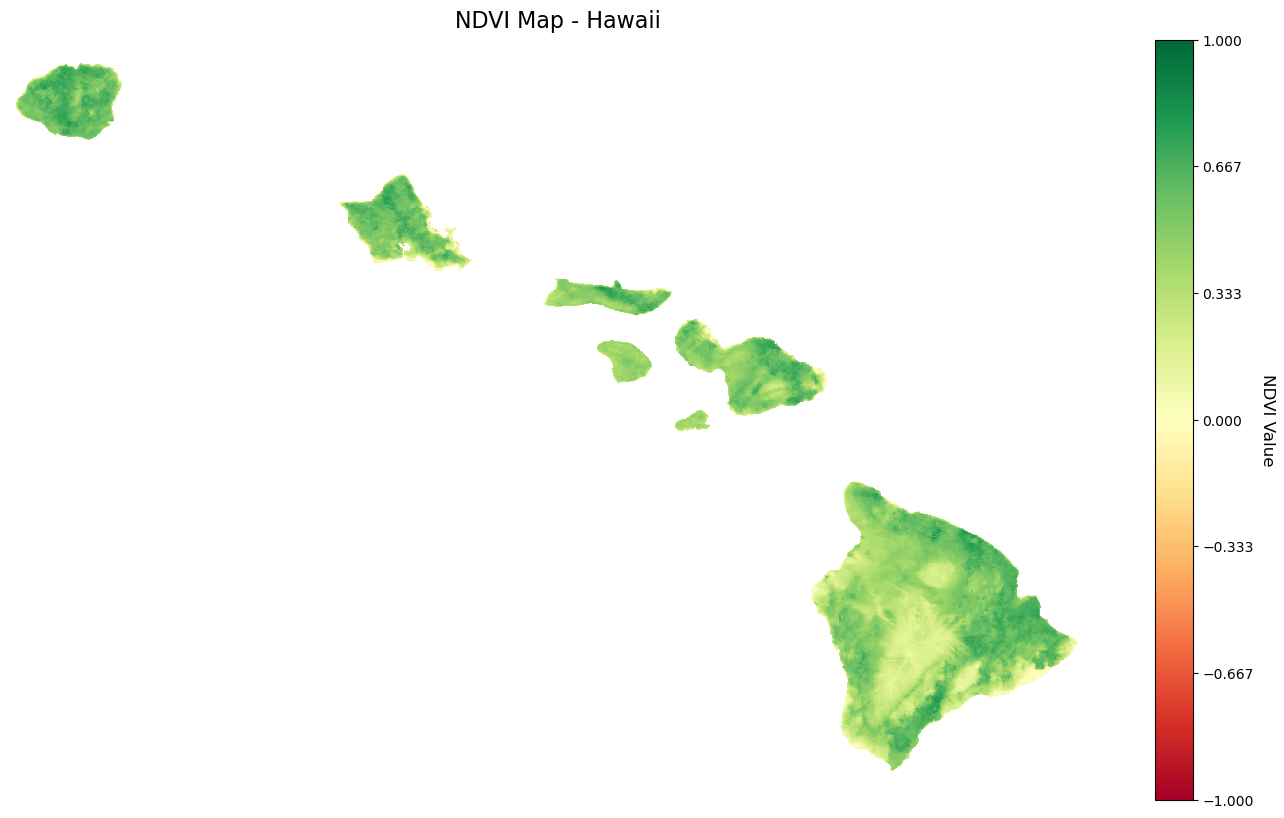

In [7]:
# Load the NDVI data
with rasterio.open(ndvi_path) as ndvi_src:
    ndvi_data = ndvi_src.read(1)  # Read the first band
    ndvi_nodata = ndvi_src.nodata
    bounds = ndvi_src.bounds
    extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]

# Mask NoData Values
ndvi_data = np.ma.masked_equal(ndvi_data, ndvi_nodata)

# Check for Invalid Values
# Identify and mask any NaNs or infinite values
invalid_mask = np.isnan(ndvi_data) | np.isinf(ndvi_data)
if np.any(invalid_mask):
    ndvi_data = np.ma.masked_where(invalid_mask, ndvi_data)
    print("Data contains NaNs or infinite values. They have been masked.")

# Normalize NDVI Data
# Ensure NDVI values are within the standard range
ndvi_data = np.ma.clip(ndvi_data, -1, 1)

# Create Figure and Axis
fig, ax = plt.subplots(figsize=(12, 8))

# Plot NDVI Data
im = ax.imshow(ndvi_data, cmap='RdYlGn', extent=extent, interpolation='none', vmin=-1, vmax=1)

# Remove X and Y Axes
ax.axis('off') 

# Center the Title
plt.title("NDVI Map - Hawaii", fontsize=16, pad=20, ha='center')

#  Adjust Layout to Remove Excess White Space ===
plt.subplots_adjust(left=0, right=1, top=0.95, bottom=0)

# Add a Colorbar
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('NDVI Value', fontsize=12, rotation=270, labelpad=15)
cbar.set_ticks(np.linspace(-1, 1, 7))  # Adjust number of ticks as needed
cbar.ax.tick_params(labelsize=10)

# Display the Plot
plt.show()

### Aspect

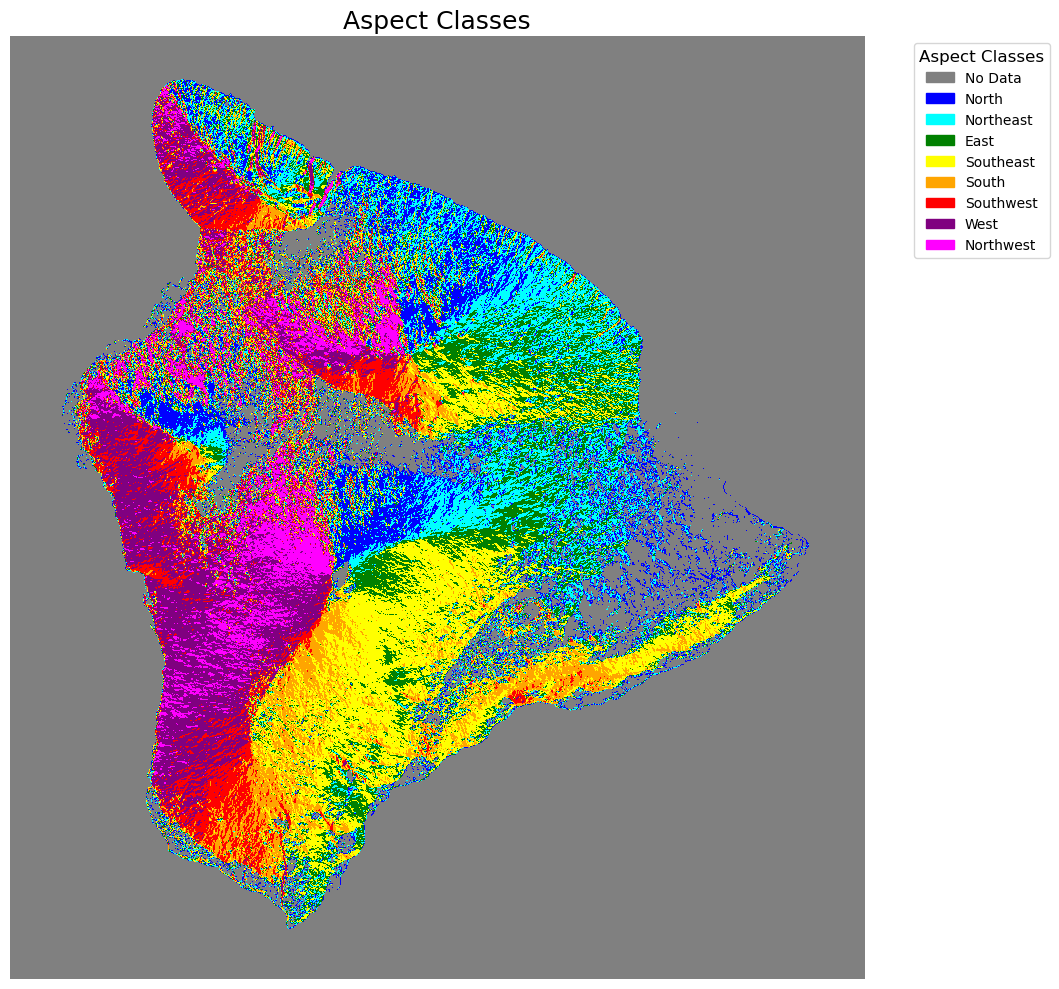

In [8]:
# Load the aspect data
with rasterio.open(aspect_path) as aspect_dataset:
    aspect_data = aspect_dataset.read(1)
    aspect_transform = aspect_dataset.transform
    aspect_crs = aspect_dataset.crs
    aspect_nodata = aspect_dataset.nodata
    # Get the bounds of the raster
    xmin, ymin, xmax, ymax = aspect_dataset.bounds

# Identify ocean areas (aspect < 0) or lack of data
ocean_mask = aspect_data < 0 

# Mask ocean and NoData areas
aspect_valid = np.ma.masked_where(ocean_mask , aspect_data)

# Proceed to classify aspect data into cardinal directions
aspect_classes = np.zeros_like(aspect_data, dtype=int)

# Assign classes based on aspect degrees
aspect_classes[(aspect_valid >= 0) & (aspect_valid < 22.5)] = 1   # North
aspect_classes[(aspect_valid >= 22.5) & (aspect_valid < 67.5)] = 2  # Northeast
aspect_classes[(aspect_valid >= 67.5) & (aspect_valid < 112.5)] = 3 # East
aspect_classes[(aspect_valid >= 112.5) & (aspect_valid < 157.5)] = 4 # Southeast
aspect_classes[(aspect_valid >= 157.5) & (aspect_valid < 202.5)] = 5 # South
aspect_classes[(aspect_valid >= 202.5) & (aspect_valid < 247.5)] = 6 # Southwest
aspect_classes[(aspect_valid >= 247.5) & (aspect_valid < 292.5)] = 7 # West
aspect_classes[(aspect_valid >= 292.5) & (aspect_valid < 337.5)] = 8 # Northwest
aspect_classes[(aspect_valid >= 337.5) & (aspect_valid <= 360)] = 1  # North

# Assign 'No Data' value to ocean and NoData areas
aspect_classes[ocean_mask] = 0  # Assign class 0 to 'No Data' areas

# Define class names including 'No Data'
aspect_class_names = ['No Data', 'North', 'Northeast', 'East', 'Southeast', 'South', 'Southwest', 'West', 'Northwest']

# Create a colormap including grey for 'No Data'
cmap = ListedColormap(['grey', 'blue', 'cyan', 'green', 'yellow', 'orange', 'red', 'purple', 'magenta'])

# Create patches for each aspect class
aspect_patches = [
    mpatches.Patch(color=cmap.colors[i], label=aspect_class_names[i])
    for i in range(len(aspect_class_names))
]

# Plot the classified aspect data
fig, ax = plt.subplots(figsize=(15, 10))  # Increased figure size for better readability

# Compute the extent of the raster for accurate geographical representation
extent = [xmin, xmax, ymin, ymax]

# Plot the aspect classes with the custom colormap
im = ax.imshow(aspect_classes, cmap=cmap, extent=extent, origin='upper')
ax.set_title("Aspect Classes", fontsize=18)
ax.axis('off') 

# Add the legend with patches
# Determine the number of columns based on the number of classes for better layout
num_classes = len(aspect_class_names)

# Add legend outside the plot
ax.legend(
    handles=aspect_patches,
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    fontsize=10,
    title="Aspect Classes",
    title_fontsize=12,
    ncol=1
)

plt.tight_layout()
plt.show()

### Elevation

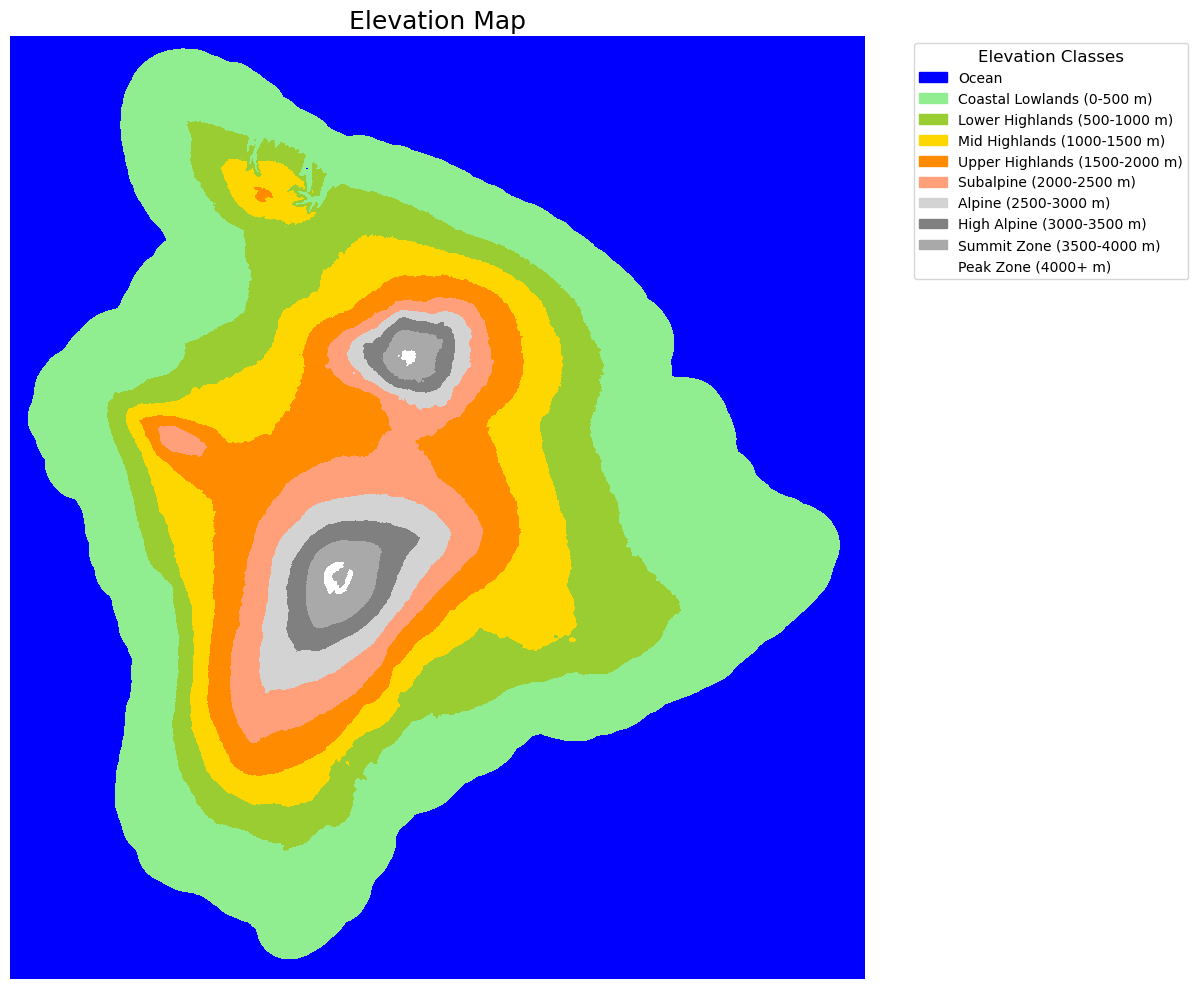

In [9]:
# Load the elevation data
with rasterio.open(elevation_path) as elevation_dataset:
    elevation_data = elevation_dataset.read(1)
    elevation_transform = elevation_dataset.transform
    elevation_crs = elevation_dataset.crs
    elevation_nodata = elevation_dataset.nodata
    xmin, ymin, xmax, ymax = elevation_dataset.bounds

# Handle NoData values
elevation_data = np.ma.masked_equal(elevation_data, elevation_nodata)

# Identify ocean areas (elevation < -1) or lack of data
ocean_mask = elevation_data < -1

# Mask ocean areas in the elevation data
elevation_land = np.ma.masked_where(ocean_mask, elevation_data)

# Convert elevation_land to float32 to save memory
elevation_land = elevation_land.astype(np.float32)

# Define elevation thresholds (example values)
elevation_bins = [0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4250]

# Perform digitization and convert output to uint8
elevation_classes = np.digitize(elevation_land, bins=elevation_bins).astype(np.uint8)

# Assign class names 
class_names = [
    'Coastal Lowlands (0-500 m)',
    'Lower Highlands (500-1000 m)',
    'Mid Highlands (1000-1500 m)',
    'Upper Highlands (1500-2000 m)',
    'Subalpine (2000-2500 m)',
    'Alpine (2500-3000 m)',
    'High Alpine (3000-3500 m)',
    'Summit Zone (3500-4000 m)',
    'Peak Zone (4000+ m)'
]

# Create a custom colormap for the land elevation classes
land_colors = [
    'lightgreen',    # Coastal Lowlands
    'yellowgreen',   # Lower Highlands
    'gold',          # Mid Highlands
    'darkorange',    # Upper Highlands
    'lightsalmon',   # Subalpine
    'lightgrey',     # Alpine
    'grey',          # High Alpine
    'darkgrey',      # Summit Zone
    'white'          # Peak Zone
]

# **Update class names and colors to include 'Ocean' only once**
class_names_full = ['Ocean'] + class_names
full_colors = ['blue'] + land_colors
full_cmap = ListedColormap(full_colors)

# **Create a masked array for elevation_classes using the mask from elevation_land**
elevation_classes_masked = np.ma.array(elevation_classes, mask=elevation_land.mask)

# **Use the filled method to assign ocean areas to class 0**
elevation_classes_full = elevation_classes_masked.filled(fill_value=0)

# **Create a norm for the colorbar**
norm = BoundaryNorm(np.arange(len(class_names_full) + 1) - 0.5, len(class_names_full))

# **Create patches for each class**
patches = [mpatches.Patch(color=full_colors[i], label=class_names_full[i]) for i in range(len(class_names_full))]

# **Plot the elevation classes**
fig, ax = plt.subplots(figsize=(15, 10))  # Increased figure size for better readability

im = ax.imshow(elevation_classes_full, cmap=full_cmap, extent=[xmin, xmax, ymin, ymax], origin='upper')
ax.set_title("Elevation Map", fontsize=18)
ax.axis('off')

ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title="Elevation Classes", title_fontsize=12, ncol=1)

plt.tight_layout()
plt.show()

### Slope

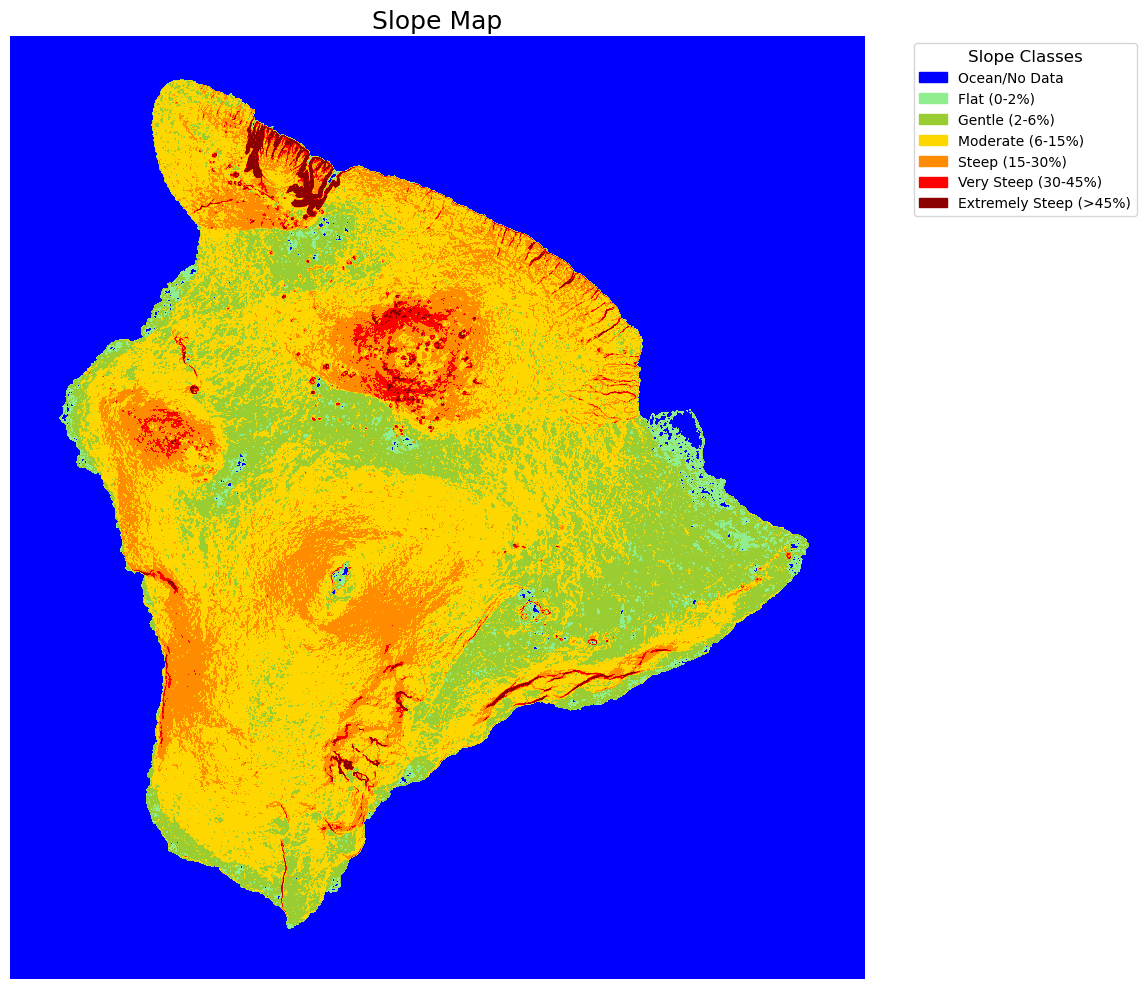

In [10]:
# Load the slope data
with rasterio.open(slope_path) as slope_dataset:
    slope_data = slope_dataset.read(1)
    slope_transform = slope_dataset.transform
    slope_crs = slope_dataset.crs
    slope_nodata = slope_dataset.nodata
    # Get the bounds of the raster
    xmin, ymin, xmax, ymax = slope_dataset.bounds

# Mask NoData values
slope_data = np.ma.masked_equal(slope_data, slope_nodata)

# Identify ocean areas (slope <= 0) or lack of data
ocean_mask = slope_data <= 0  # Adjust condition based on your data

# Combine with NoData mask
nodata_mask = slope_data.mask
ocean_mask = ocean_mask | nodata_mask

# Apply land mask to slope data
slope_land = np.ma.masked_where(ocean_mask, slope_data)

# Convert slope_land to float32 to save memory
slope_land = slope_land.astype(np.float32)

# Define slope thresholds (percent)
slope_bins = [0, 2, 6, 15, 30, 45, np.inf]

# Assign class names **excluding 'Ocean'**
slope_class_names = [
    'Flat (0-2%)',
    'Gentle (2-6%)',
    'Moderate (6-15%)',
    'Steep (15-30%)',
    'Very Steep (30-45%)',
    'Extremely Steep (>45%)'
]

# Perform digitization and convert output to uint8
slope_classes = np.digitize(slope_land, bins=slope_bins).astype(np.uint8)

# Create a masked array for slope_classes using the mask from slope_land
slope_classes_masked = np.ma.array(slope_classes, mask=slope_land.mask)

# Use the filled method to assign ocean areas to class 0
slope_classes_full = slope_classes_masked.filled(fill_value=0)

# Update class names and colors to include 'Ocean' only once
slope_class_names_full = ['Ocean/No Data'] + slope_class_names
slope_colors = [
    'blue',         # Ocean
    'lightgreen',   # Flat
    'yellowgreen',  # Gentle
    'gold',         # Moderate
    'darkorange',   # Steep
    'red',          # Very Steep
    'darkred'       # Extremely Steep
]
slope_cmap = ListedColormap(slope_colors)

# Create patches for each slope class
elevation_patches = [
    mpatches.Patch(color=slope_colors[i], label=slope_class_names_full[i])
    for i in range(len(slope_class_names_full))
]

# Create a figure and axes
fig, ax = plt.subplots(figsize=(15, 10))  # Increased figure size for better readability

# Compute the extent of the raster for accurate geographical representation
extent = [xmin, xmax, ymin, ymax]

# Plot the slope classes with the custom colormap
im = ax.imshow(slope_classes_full, cmap=slope_cmap, extent=extent, origin='upper')
ax.set_title("Slope Map", fontsize=18)
ax.axis('off')  # Hide the axes

# Add the legend with patches
# Determine the number of columns based on the number of classes for better layout
num_classes = len(slope_class_names_full)

# Add legend outside the plot
ax.legend(
    handles=elevation_patches,
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    fontsize=10,
    title="Slope Classes",
    title_fontsize=12,
    ncol=1
)

plt.tight_layout()
plt.show()
